# Analysis of gene regulatory networks inferred from COVID-19 patients

This notebook contains the differential analysis of gene regulatory networks (GRNs) computed on scRNA-seq data of COVID-19 patients ([Liao *et al.*, 2020](https://www.nature.com/articles/s41591-020-0901-9)). The term "differential" depicts the comparison of properties between different networks, each **tailored to a cohort of patients**. For example, this notebook would be useful to answer the following questions:

- What are the **patient-specific** differences between GRNs?
- Can we **link** the **interaction** between genes to the **severity** of SARS-COV-2 infection?
- Do differences in patient-tailored GRNs have **clinical relevance**?



# Setting up the environment..

In [15]:
# Generic
import sys  # managing environmental variables
import os  # file system
import warnings  # managing warnings
from glob import glob  # globbing
import multiprocessing  # parallel execution

# Data managing
import ndex2  # database of biological network
import numpy as np  # scientific programming
import pandas as pd  # working with tabular data

# Graphs
import networkx as nx  # working with network data
import igraph as ig  # working with network data
import leidenalg as la  # community detection
from community import community_louvain  # community detection
from venn import venn, pseudovenn, generate_petal_labels, draw_venn, draw_pseudovenn6  # venn diagram visualization

# Visualization
import matplotlib as mpl  # general visualization
import matplotlib.pyplot as plt  # general visualization
import seaborn as sns  # fancy visualizations
import colorcet as cc  # colormaps
from matplotlib.colors import ListedColormap  # colormaps
import matplotlib.patches as mpatches  # color patches
from wordcloud import WordCloud  # wordcloud visualization
import matplotlib_venn_wordcloud  # workcloud visualization

# Tools/utils
from sklearn.preprocessing import MinMaxScaler  # scaling data
from collections import Counter  # item counter
from functools import reduce  # for aggregate functions
from termcolor import colored  # colored text output
from tqdm.notebook import tqdm  # progress bar logging
import itertools  # tools for iterative objects

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~/scGRN_analysis'))
multiprocessing.process.ORIGINAL_DIR = os.path.abspath(os.getcwd())

# Getting the tools for GRN analysis
import scGRN

# Jupyter utils
from IPython.display import display  # displaying results in jupyter
from ipywidgets import *  # interactive widgets

# Bridge to R
import rpy2.rinterface
%load_ext rpy2.ipython

# To reload packages - # %autoreload 2
%load_ext autoreload
# To obtain line-by-line profile of execution time
%load_ext line_profiler

# Other parameters
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
_N_JOBS = max(1, multiprocessing.cpu_count() - 2)
_SEED = 42
np.random.seed(_SEED)
_NODE_SIZE = 1200
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.dpi'] = 200

# Loading ggplot2 default colors
colors = scGRN.ggcolors

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Setting up data
## Getting metadata

In [16]:
# Setting pathways to data files
_PROJ_HOME = '/gpfs/projects/bsc08/shared_projects/scGRN_analysis'  # also scGRN._PROJ_HOME
_FMETA = f'{_PROJ_HOME}/Data_home/data/GSE145926_RAW/metadata.tsv'  # also scGRN._META_FILE
_DATA_HOME = f'{_PROJ_HOME}/Data_home/res/covid_19'  # also scGRN._DATA_HOME
_FIG_HOME = f'{_PROJ_HOME}/Data_home/notebook_figs'

# Loading patient metadata
full_meta = scGRN.ana.get_meta(_DATA_HOME, _FMETA)

# Displaying full metadata
print('Full metadata:')
full_meta

Full metadata:


,group,file,num_cells,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,...,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
id,,,,,,,,,,,,,,,,,,,,,
C51,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,9431.0,8348.0,608.0,215.0,98.0,70.0,68.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C52,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,8696.0,8611.0,13.0,23.0,3.0,14.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,907.0,338.0,411.0,45.0,5.0,51.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C141,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1449.0,197.0,932.0,48.0,5.0,86.0,96.0,33.0,...,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C142,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1790.0,482.0,996.0,39.0,13.0,67.0,113.0,20.0,...,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C144,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,452.0,37.0,181.0,41.0,8.0,73.0,34.0,14.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C143,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,14933.0,2048.0,1394.0,154.0,33.0,7489.0,562.0,72.0,...,3005.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
C145,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,15550.0,6960.0,719.0,859.0,46.0,5616.0,421.0,58.0,...,635.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C146,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,2545.0,247.0,61.0,36.0,NaN,127.0,14.0,3.0,...,1632.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,NaN


## Setting up namespace

Here we will define useful info that will help us to navigate through data.

In [17]:
# Data types
_PAT_TYPES = ['C', 'M', 'S']  # control, moderate and severe
_NET_TYPES = ['all', 'TF', 'ctx']  # all gene-gene connections, TF-target connections, enriched TF-target connections

# Defining quantile when filtering low-confident nodes from GRNs
_Q_THRESH = 0.95

# Limiting the metadata to certain patients/cell types to fit into RAM
_LOADED_PATIENTS = ['C51', 'C141', 'C148']
_LOADED_CELL_TYPES = ['all_data', 'T_cells', 'Macrophage', 'NK_cell', 'Monocyte']

# Putting loaded patients at the front
full_meta = full_meta.loc[_LOADED_PATIENTS + full_meta.drop(index=_LOADED_PATIENTS).index.to_list()]

# Getting cell type count for each patient
full_cell_type_dist = full_meta.iloc[:, 3:]

# Getting information about all patients
_ALL_CELL_TYPES = full_cell_type_dist.columns.to_list()
_ALL_PATIENTS = full_meta.index.to_list()
_ALL_PAT_CELL_TYPES = {  # available cell types per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=False).remove('all_data') for pat in _ALL_PATIENTS
}
_ALL_PAT_FILENAMES = {  # obtained data files per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=True) for pat in _ALL_PATIENTS
}
_ALL_FIG_DIRS = {
    **{  # figure directory paths per patient
        pat: os.path.join(_DATA_HOME, pat, 'figs/grnboost2') for pat in _ALL_PATIENTS
    }, 
    **{  # common figure directory for aggregated patient data
        pat: _FIG_HOME for pat in ['C', 'M', 'S', 'all_data']
    }
}

for fig_dir in _ALL_FIG_DIRS.values():  # creating folders for figures per patient
    os.makedirs(fig_dir, exist_ok=True)

# Loading exemplary data - also possible to use scGRN.ana.get_sc_data(data='all_data', pat=ex_pat)
ex_pat = 'C141'
ex_df = pd.read_csv(os.path.join(_DATA_HOME, f'{ex_pat}/data/Seurat/raw_data.tsv'), sep='\t').T

# Quick reporting
print(f'As an example, the expression matrix of {colored(ex_pat, "green")} patient contains '
      f'{colored(ex_df.shape[0], "green")} cells and {colored(ex_df.shape[1], "green")} genes:')
display(ex_df.head())
print('Common cell types among different patients (full metadata):')
display(full_cell_type_dist.T.dropna())

As an example, the expression matrix of C141 patient contains 1449 cells and 20271 genes:


,AL627309.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC240274.1
AAACCTGAGATGTCGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAATCCGAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGGTCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTTTAGCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGTCAATCACG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Common cell types among different patients (full metadata):


id,C51,C141,C148,C52,C100,C142,C144,C143,C145,C146,C149,C152
Macrophage,8348.0,197.0,98.0,8611.0,338.0,482.0,37.0,2048.0,6960.0,247.0,176.0,466.0
T_cells,608.0,932.0,122.0,13.0,411.0,996.0,181.0,1394.0,719.0,61.0,681.0,397.0
DC,215.0,48.0,24.0,23.0,45.0,39.0,41.0,154.0,859.0,36.0,80.0,41.0
Monocyte,70.0,86.0,641.0,14.0,51.0,67.0,73.0,7489.0,5616.0,127.0,691.0,795.0
NK_cell,68.0,96.0,36.0,5.0,20.0,113.0,34.0,562.0,421.0,14.0,59.0,74.0
B_cell,9.0,33.0,8.0,2.0,12.0,20.0,14.0,72.0,58.0,3.0,38.0,317.0
Epithelial_cells,7.0,37.0,52.0,25.0,18.0,38.0,54.0,145.0,207.0,417.0,41.0,201.0


## Available data reporting

Here we will visualize available data through dataframe formatting. Also we will show what cell types (and their quantity) are present in each patients.

In [18]:
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, yellow

# Getting scRNA-seq data availability
_AVAIL_scDATA = scGRN.ana.get_avail_sc_data(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Displaying the scRNA-seq data availability
display(scGRN.util.style_bool_df(_AVAIL_scDATA))

# Printing the legend
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


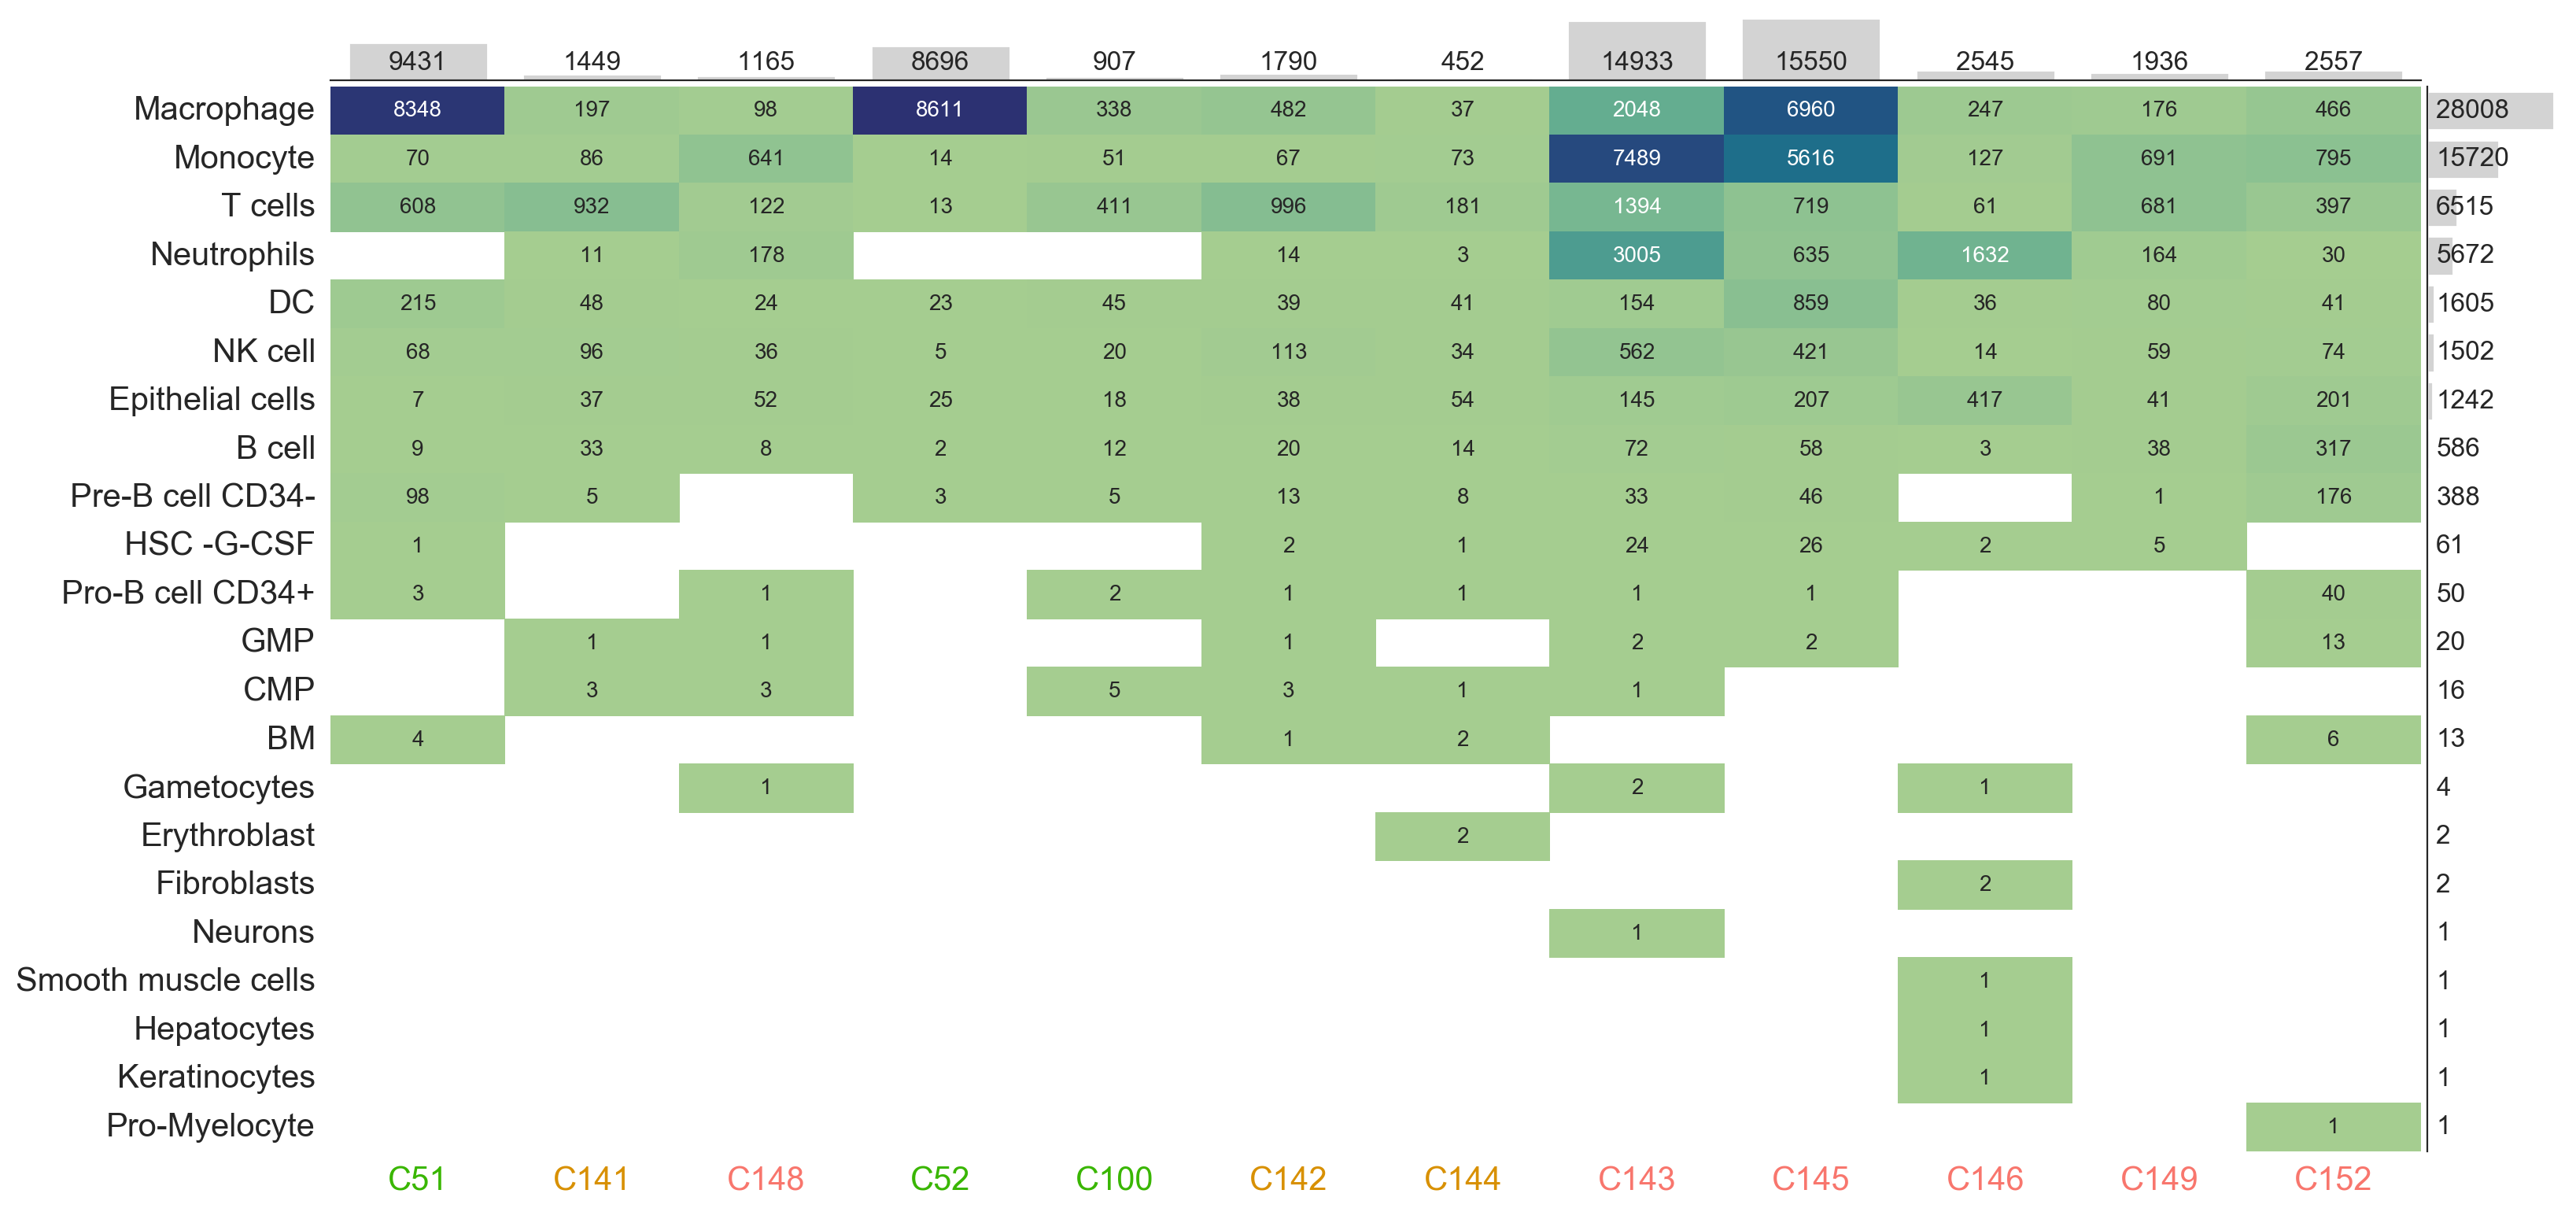

In [19]:
# Heatmap of cell type count distribution for different patients
scGRN.ana.plot_avail_cell_types(
    meta=full_meta,
    save_as=os.path.join(_FIG_HOME, 'EDA_cell_type_dist.pdf')
)

## Setting up useful functions - mainly for `ipywidgets`

In [24]:
def data_fn_to_cell_type(data):
    """
    Transform data file identifier to cell type, e.g. "raw_data_Macrophage" -> "Macrophage"
    """
    
    return 'all_data' if data == 'raw_data' else data.replace('raw_data_', '')

def load_grn(pat, cell_type, net_type, filtered=None):
    """
    Load the NetworkX GRN with additional check if it is present in RAM.
    """
    
    tag = f'net_{net_type}' if filtered is None else f'filtered_net_{net_type}'
    
    try:
        G = grnboost2_meta[pat][cell_type][f'net_{net_type}']
    except KeyError:
        G = scGRN.ana.get_nx_graph(
            cell_type, net_type=net_type, pat=pat, 
            filtered=filtered, data_home=_DATA_HOME)
        
    return G

def load_adj_list(pat, cell_type, net_type, filtered=None):
    """
    Load the adjacency list GRN with additional check if it is present in RAM.
    """
    
    tag = f'adj_list_{net_type}' if filtered is None else f'filtered_adj_list_{net_type}'
    
    try:
        G = grnboost2_meta[pat][cell_type][f'adj_list_{net_type}']
    except (NameError, KeyError):
        G = scGRN.ana.get_adj_list(cell_type, net_type=net_type, pat=pat, 
                                   filtered=filtered, data_home=_DATA_HOME)
        
    return G

def format_pat(p):
    """
    Format patient name `p` to a nice view, e.g. "C51 (C) - RAM", "C".
    """
    
    if p in ['all_data'] + _PAT_TYPES:
        return p
    else:
        is_RAM = ' - RAM' if p in _LOADED_PATIENTS else ''
        pat_type = f"{full_meta.loc[p, 'group']}"
        return f"{p} ({pat_type}){is_RAM}"

def format_data(p, ct, add_ram_tag=True):
    """
    Format data name corresponding to `p` (patient) and `ct` (cell type) to a nice view, e.g. "T_cells (2800 cells)""
    """
    
    if ct == 'all_data':
        tag = 'all_data'
        col_key = 'num_cells'
    else:
        col_key = tag = ct
            
    if p in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == p] if p != 'all_data' else full_meta
        num_cells = int(curr_meta[col_key].sum())
    else:
        num_cells = int(full_meta.loc[p, col_key])
        
    is_RAM = ' - RAM' if tag in _LOADED_CELL_TYPES and add_ram_tag else ''
        
    return f'{tag} ({num_cells} cells){is_RAM}'

def gen_avail_data(_):
    """
    Generates a list of data options depending on passed information (for `ipywidgets`).
    """
    c_type_dropdown.options = [
        (
            format_data(p_dropdown.value, c_type), 
            c_type
        ) for c_type in scGRN.ana.get_avail_pat_nx(n_type_dropdown.value, p_dropdown.value, as_data_fn=False)
    ]
    
def gen_dropdowns():
    """
    Generate `ipywidgets` Dropdown objects to interact with jupyter notebook. 
    """
    _n_type_dropdown = Dropdown(
        description='Net type:', options=_NET_TYPES
    )
    _p_dropdown = Dropdown(
        description='Patient:', 
        options=[(format_pat(p), p) for p in _ALL_PATIENTS + ['C', 'M', 'S', 'all_data']]
    )
    _c_type_dropdown = Dropdown(
        description='Cell type:', 
        options=[
            (
                format_data(_ALL_PATIENTS[0], c_type), 
                c_type
            ) for c_type in scGRN.ana.get_avail_pat_nx('all', _ALL_PATIENTS[0], as_data_fn=False)
        ]
    )
    _p_dropdown.observe(gen_avail_data, names='value')
    _n_type_dropdown.observe(gen_avail_data, names='value')

    return _p_dropdown, _c_type_dropdown, _n_type_dropdown
    
sf_dropdown = Dropdown(
    description='Save figure:', options=[False, True]
)
fltrd_dropdown = Dropdown(
    description=f'Filtered (quantile threshold={_Q_THRESH}): ', options=[False, True]
)

## Availability of NetworkX graphs for different datasets

In [21]:
# Getting adjacency list/NetworkX object availability matrices
_AVAIL_ADJ_LISTs = scGRN.ana.get_avail_adj_lists(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)
_AVAIL_Gs = scGRN.ana.get_avail_nx_graphs(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Visualizing the GRN availability matrix
for net_type in _NET_TYPES:
    print(f"{colored(net_type, 'cyan')}-type networks")
    display(scGRN.util.style_bool_df(_AVAIL_Gs[net_type]))

# Printing the legend
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, #8B8000
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

all-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


TF-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


ctx-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,?,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,?,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,✕,?,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


## Quality checks
### Edge co-occurrence of the same patient type

Here we will produce Venn diagrams and edge importance distributions in GRNs computed on different subsets of data each corresponding to one patient type (i.e. "C", "M", "S"). We assume that patients of the same patient type should have **similar** gene-gene edges or at least **same** edge importances.

In [8]:
def venn_link_cooccur_per_ctype(net_type, pat_type, cell_type, filtered, save_fig):
    """
    Plot a Venn diagram to show co-occurent GRN links (of `net_type` GRNs) across patients of chosen `cell_type`.
    
    :param net_type: Network type
    :param pat_type: Patient type (either 'C', 'M', 'S')
    :param cell_type: Provided cell type
    :param filtered: True if get filtered GRN, False otherwise
    :param save_fig: Whether to save the figure
    """
 
    adj_lists = {}
    group_pats = full_meta['group'].loc[lambda x: x == pat_type].index
    for pat_1 in group_pats:
        for pat_2 in group_pats:
            if pat_1 != pat_2:

                # Reading adjacency lists
                adj_list_1 = scGRN.ana.get_adj_list(
                    cell_type=cell_type, net_type=net_type, pat=pat_1, filtered=_Q_THRESH if filtered else None
                )
                adj_list_2 = scGRN.ana.get_adj_list(
                    cell_type=cell_type, net_type=net_type, pat=pat_2, filtered=_Q_THRESH if filtered else None
                )

                # Storing adjacency lists
                if pat_1 not in adj_lists:
                    adj_lists[pat_1] = adj_list_1
                if pat_2 not in adj_lists:
                    adj_lists[pat_2] = adj_list_2
             
    # Creating a venn diagramm
    f, ax = plt.subplots(figsize=(15, 7))
    plot_venn = venn if len(adj_lists) < 5 else pseudovenn
    plot_venn({
        pat: set(zip(adj_list['TF'], adj_list['target'])) for pat, adj_list in adj_lists.items()
    }, fmt='{percentage:.1f}%', hint_hidden=False, ax=ax)
    ax.set_title(f'Venn diagramm of edge co-occurrence in "{pat_type}" patients\n'
                 f'cell_type={cell_type}, net_type={net_type}, filtered={filtered}')
 
    if save_fig:
        plt.savefig(os.path.join(_FIG_HOME, f'{pat_type}_{cell_type}_{net_type}_venn_diagram_cooccurent_links.pdf'), bbox_inches='tight', dpi=200)         
        
p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
        
widget = interact(
    venn_link_cooccur_per_ctype, 
    net_type=n_type_dropdown,
    pat_type=p_type_dropdown, 
    cell_type=c_type_dropdown, 
    filtered=fltrd_dropdown,
    save_fig=sf_dropdown,
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

#### Cell count between patient types

In [22]:
def pat_type_cell_count(c_type, save_fig):
    """
    Plot cell count for different patient types ('C', 'M', 'S') with given `c_type`.
    
    :param c_type: Provided cell type
    :param save_fig: Whether to save the figure
    """
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 7))
        full_meta.groupby('group')[c_type].sum().plot(
            kind='bar', ax=ax, rot=0, color=[colors['green'], colors['yellow'], colors['red']]
        )
        plt.xlabel('Patient type')
        plt.ylabel('Number of cells')
        
        ax.grid(True)
        plt.title(f'The cell count for "{c_type}" cells')
        
        if save_fig:
            plt.savefig(os.path.join(_FIG_HOME, f'{c_type}_cell_count_different_pat_types.pdf'))
    
c_type_dropdown = Dropdown(
    description='Cell type:', 
    options=[
        (
            format_data('all_data', c_type, add_ram_tag=False), 
            c_type
        ) for c_type in full_cell_type_dist.columns
    ]
)

widget = interact(
    pat_type_cell_count, 
    c_type=c_type_dropdown, 
    save_fig=sf_dropdown
)

interactive(children=(Dropdown(description='Cell type:', options=(('Macrophage (28008 cells)', 'Macrophage'), …

#### Venn diagram of gene-gene link co-occurence between patient types

In [23]:
def venn_link_cooccur(c_type_1, c_type_2, save_fig):
    """
    Plot 2 Venn diagrams (per chosen cell type) to show co-occurent GRN links (in 'all' GRNs) across various patient types ('C', 'M', 'S').
    
    :param c_type_1: Provided cell type (1)
    :param c_type_2: Provided cell type (2)
    :param save_fig: Whether to save the figure
    """
    
    top_n = 5
    n_bins = 100
    fontsize = 25
    cell_types = [c_type_1, c_type_2]
    cmap = ListedColormap([colors['green'], colors['yellow'], colors['red']])

    adj_lists = {
        ct: {
            t: load_adj_list(pat=t, cell_type=ct, net_type='all', filtered=_Q_THRESH) for t in _PAT_TYPES
        } for ct in cell_types
    }

    f, ax = plt.subplots(1, 2, figsize=(15, 7))

    for i, (ct, curr_adj_lists) in enumerate(adj_lists.items()):

        venn({
            t: set(zip(adj_list['TF'], adj_list['target'])) for t, adj_list in curr_adj_lists.items()
        }, fmt='{percentage:.1f}%', hint_hidden=False, ax=ax[i], cmap=cmap)
        ax[i].set_title(ct, fontsize=fontsize, fontweight='bold')
        ax[i].get_legend().remove()

    f.legend(
        handles = [
            mpatches.Patch(color=c, label=t, alpha=0.4) 
            for c, t in zip([colors['green'], colors['yellow'], colors['red']], _PAT_TYPES)
        ], 
        ncol=3, loc='upper center')

    if save_fig:
            plt.savefig(os.path.join(_FIG_HOME, f'{c_type_1}_{c_type_2}_pat_types_venn.pdf'), bbox_inches='tight')
            
c_types = _ALL_CELL_TYPES
c_type_1_dropdown = Dropdown(
    description='Cell type (1):', 
    options=c_types
)
c_type_2_dropdown = Dropdown(
    description='Cell type (2):', 
    options=c_types[1:] + [c_types[0]]
)

widget = interact(
    venn_link_cooccur, 
    c_type_1=c_type_1_dropdown, 
    c_type_2=c_type_2_dropdown,
    save_fig=sf_dropdown
) 

interactive(children=(Dropdown(description='Cell type (1):', options=('Macrophage', 'T_cells', 'DC', 'Pre-B_ce…

#### Venn diagram of common TFs between patient types

In [16]:
def venn_TF_present(c_type_1, c_type_2, save_fig):
    """
    Plot 2 Venn diagrams (per chosen cell type) to show activated TFs (in 'ctx' GRNs) across various patient types ('C', 'M', 'S').
    
    :param c_type_1: Provided cell type (1)
    :param c_type_2: Provided cell type (2)
    :param save_fig: Whether to save the figure
    """
    
    max_freq = 5
    fontsize = 30
    cell_types = [c_type_1, c_type_2]
    
    TFs = {
        ct: {
            t: reduce(
                lambda x, y: x + y, 
                load_adj_list(pat=t, cell_type=ct, net_type='ctx', filtered=_Q_THRESH)[['TF', 'target']]
                    .groupby('TF').nunique().reset_index()
                    .assign(scaled_num=lambda x: scGRN.util.scale_int(x.target, 1, max_freq))
                    .apply(lambda row: [row['TF']]*row['scaled_num'], axis=1)
            ) for t in _PAT_TYPES
        } for ct in cell_types
    }
    
    word_to_frequency = {
        ct: dict(Counter(list(
            reduce(lambda x, y: x + y, list(TFs[ct].values()))
        ))) for ct in cell_types
    }
    
    # Cut-off the prevalence of highly-active TFs
    word_to_frequency = {
        ct: {
            tf: (num if num < max_freq else max_freq) for tf, num in word_to_frequency[ct].items()
        } for ct in cell_types
    }
    
    f, ax = plt.subplots(1, len(cell_types), figsize=(25, 10))

    for a, ct in zip(ax, cell_types):
        matplotlib_venn_wordcloud.venn3_wordcloud(
            [set(tf_list) for tf_list in TFs[ct].values()], 
            set_labels=_PAT_TYPES,
            set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
            ax=a, 
            word_to_frequency=word_to_frequency[ct],
            wordcloud_kwargs=dict(min_font_size=6, width=1200, height=800)
        )

        a.set_title(ct, fontsize=fontsize, fontweight='bold')
        
    if save_fig:
        plt.savefig(os.path.join(_FIG_HOME, f'{c_type_1}_{c_type_2}_pat_types_venn.pdf'), bbox_inches='tight')
            
c_types = _ALL_CELL_TYPES
c_type_1_dropdown = Dropdown(
    description='Cell type (1):', 
    options=c_types
)
c_type_2_dropdown = Dropdown(
    description='Cell type (2):', 
    options=c_types[1:] + [c_types[0]]
)

widget = interact(
    venn_TF_present, 
    c_type_1=c_type_1_dropdown, 
    c_type_2=c_type_2_dropdown,
    save_fig=sf_dropdown
) 

interactive(children=(Dropdown(description='Cell type (1):', options=('Macrophage', 'T_cells', 'DC', 'Pre-B_ce…

### Edge importance distribution of the same patient type

In [9]:
def edge_imp_dist_per_ctype(net_type, pat_type, cell_type, filtered, save_fig):
    """
    Plot a histogram distribution of edge importances (of `net_type` GRNs) across patients of chosen `cell_type`.
    
    :param net_type: Network type
    :param pat_type: Patient type (either 'C', 'M', 'S')
    :param cell_type: Provided cell type
    :param filtered: True if get filtered GRN, False otherwise
    :param save_fig: Whether to save the figure
    """
 
    adj_lists = {}
    group_pats = full_meta['group'].loc[lambda x: x == pat_type].index
    for pat_1 in group_pats:
        for pat_2 in group_pats:
            if pat_1 != pat_2:

                # Reading adjacency lists
                adj_list_1 = scGRN.ana.get_adj_list(
                    cell_type=cell_type, net_type=net_type, pat=pat_1, filtered=_Q_THRESH if filtered else None
                )
                adj_list_2 = scGRN.ana.get_adj_list(
                    cell_type=cell_type, net_type=net_type, pat=pat_2, filtered=_Q_THRESH if filtered else None
                )

                # Storing adjacency lists
                if pat_1 not in adj_lists:
                    adj_lists[pat_1] = adj_list_1
                if pat_2 not in adj_lists:
                    adj_lists[pat_2] = adj_list_2
             
    # Plotting the distributions of the edge importances
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.concat([adj_list.assign(patient=pat) for pat, adj_list in adj_lists.items()]).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='importance', hue='patient', kde=True, 
                 palette=sns.color_palette('bright')[:len(adj_lists)], 
                 alpha=0.2, ax=ax)
    ax.set_title(f'The distribution of edge importances\n'
                 f'pat_type={pat_type}, cell_type={cell_type}, net_type={net_type}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Count')
    ax.set_ylim(bottom=1)
    ax.set_yscale('log')

    if save_fig:
        plt.savefig(os.path.join(_FIG_HOME, f'{pat_type}_{cell_type}_{net_type}_link_dist.pdf'), bbox_inches='tight', dpi=200)         
        
p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
        
widget = interact(
    edge_imp_dist_per_ctype,
    net_type=n_type_dropdown,
    pat_type=p_type_dropdown, 
    cell_type=c_type_dropdown, 
    filtered=fltrd_dropdown,
    save_fig=sf_dropdown,
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

## Comparing each network with the biggest network ("C"+"M"+"S) as a reference

##### Unique links in subnetwork
Here we will try to find differences in graphs for each specific cell type between patients..

In [10]:
def DG_ana(net_type, pat, cell_type, compare_with, filtered, quantile_normalization, save_fig):
    """
    Plot a histogram distribution of edge importances (of `net_type` GRNs) across patients of chosen `cell_type`.
    
    :param net_type: Network type
    :param pat: Patient type (either 'C', 'M', 'S')
    :param cell_type: Provided cell type
    :param filtered: True if get filtered GRN, False otherwise
    :param save_fig: Whether to save the figure
    """
    
    top_n = 5
    seed = 42
    sns.set_style("whitegrid")
    n_bins = 100
    
    # Loading the adjacency lists for a target network
    adj_list = scGRN.ana.get_adj_list(
        cell_type=cell_type, net_type=net_type, pat=pat, 
        filtered=_Q_THRESH if filtered else None
    )
    
    if compare_with == 'same_pat_type':
        # loading adj. list, inferred from all `cell_type` cells of the same patient type as target (e.g. 'C', 'M' or 'S')
        adj_list_ref = scGRN.ana.get_adj_list(
            cell_type=cell_type, net_type=net_type, pat=full_meta.loc[pat, 'group'], 
            filtered=_Q_THRESH if filtered else None
        )
        cell_type_ref, pat_ref = cell_type, full_meta.loc[pat, 'group']

    elif compare_with == 'same_cell_type':
        # loading adj. list, inferred from all cells of the same `cell_type`
        adj_list_ref = scGRN.ana.get_adj_list(
            cell_type=cell_type, net_type=net_type, 
            filtered=_Q_THRESH if filtered else None
        )
        cell_type_ref, pat_ref = cell_type, 'all_data'
        
    else:
        # loading adj. list, inferred on all data
        adj_list_ref = scGRN.ana.get_adj_list(
            cell_type='all_data', net_type=net_type, 
            filtered=_Q_THRESH if filtered else None
        )
        cell_type_ref, pat_ref = 'all_data', 'all_data'
        
    # Logs
    print(f'The {colored("target", "green")} network:')
    print(f'   net_type="{net_type}", pat="{colored(pat, "green")}", cell_type="{colored(cell_type, "green")}"')
    print(f'The {colored("reference", "red")} network:')
    print(f'   net_type="{net_type}", pat="{colored(pat_ref, "red")}", cell_type="{colored(cell_type_ref, "red")}"')
    
    # Getting the overlapping edges, left-unique edges, right-unique edges
    merged = adj_list.merge(adj_list_ref, on=['TF', 'target'], how='inner', suffixes=('', '_ref'))
    left_links = adj_list.merge(adj_list_ref, on=['TF', 'target'], how='left', suffixes=('', '_ref'), indicator=True).loc[lambda x: x['_merge'] == 'left_only']
    right_links = adj_list.merge(adj_list_ref, on=['TF', 'target'], how='right', suffixes=('', '_ref'), indicator=True).loc[lambda x: x['_merge'] == 'right_only']
    
    # if quantile_normalization:
    #     merged = quantile_normalization(merged)
    
    print()
    print(f'When overlapping target and reference adjacency lists, '
          f'only {len(merged)} links are preserved out of {len(adj_list)} '
          f'({len(merged) / len(adj_list) * 100:.1f} %).')
    
    # Getting fold change
    merged['FC'] = merged['importance'] / merged['importance_ref']
    merged = merged.sort_values(by='FC', ascending=False)
    
    print()
    print(f'Looking into {colored("overlapping", "blue")} edges:')
    print(f'Top {top_n} "over-expressed" edges in {pat} patient, cell type {cell_type} (by importance FC):')
    display(merged.head(top_n))
    
    print(f'Top {top_n} "under-expressed" edges in {pat} patient, cell type {cell_type} (by importance FC)')
    display(merged.tail(top_n))
    
    print()
    print(f'Looking into {colored("non-overlapping", "blue")} edges:')
    print(f'Top {top_n} unique links in {colored("target", "green")} network:')
    display(left_links.nlargest(top_n, 'importance').dropna(axis=1))
    
    print(f'Top {top_n} unique links in {colored("reference", "red")} network:')
    display(right_links.nlargest(top_n, 'importance_ref').dropna(axis=1))
    
    # Plotting the log FC distribution
    f, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(np.log10(merged['FC']), ax=ax)
    ax.set_title(f'The distribution of fold change in edge importances\n'
                 f'Target: pat_type={pat}, cell_type={cell_type}, net_type={net_type}\n'
                 f'Reference: pat_type={pat_ref}, cell_type={cell_type_ref}, net_type={net_type}')
    ax.set_xlabel('Importance log(FC)')
    ax.set_ylabel('Count')
    
    # Plotting the distribution of edge importance
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.DataFrame({
        'importance': pd.concat([merged['importance'], merged['importance_ref']]), 
        'Graph': [pat]*len(merged) + [pat_ref]*len(merged)
    }).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='importance', hue='Graph', kde=True, palette=sns.color_palette('bright')[:2], ax=ax)
    ax.set_title(f'The difference in distribution of edge importances\n'
                 f'Target: pat_type={pat}, cell_type={cell_type}, net_type={net_type}\n'
                 f'Reference: pat_type={pat_ref}, cell_type={cell_type_ref}, net_type={net_type}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Count')
    ax.set_xscale('log')
    
    # Plotting the graph, highlighting the unique links
#     f, ax = plt.subplots(figsize=(25, 45))
    
#     G = nx.from_pandas_edgelist(merged, source='TF', target='target', 
#                                 edge_attr=['FC', 'importance_pat', 'importance_all'], 
#                                 create_using=nx.DiGraph)
#     pos = nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
#     cmap = sns.color_palette("Reds", as_cmap=True)
    
#     nx.draw(G, pos, ax=ax, arrowstyle="->", arrowsize=20, 
#             connectionstyle=f'arc3, rad = 0.25', width=0.4, 
#             edge_color='k', node_color='k', node_size=50, alpha=0.2) 
#     nx.draw_networkx_edges(
#         G, pos, ax=ax, arrowstyle="->", arrowsize=20, 
#         edgelist = [(row['TF'], row['target']) for _, row in merged.head(10).iterrows()],
#         connectionstyle=f'arc3, rad = 0.25', width=1, edge_color='r',
#         alpha=0.5
#     )

#     ax.set_title(f'Differentially significnat links',fontsize=30)
#     plt.axis('off')
    
    # if save_fig:
    #     i = 0
    #     while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
    #         i += 1
    #     plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')

p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()

cmp_with_dropdown = Dropdown(
    description='Compare with:', options=['same_cell_type', 'same_pat_type', 'all_cells'],
    style = {'description_width': 'initial'}
)
qnt_norm_dropdown = Dropdown(
    description='Quantile normalization:', options=[True, False]
)
        
widget = interactive(
    DG_ana,
    {'manual': True},
    net_type=n_type_dropdown,
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    compare_with=cmp_with_dropdown,
    quantile_normalization=qnt_norm_dropdown,
    filtered=fltrd_dropdown,
    save_fig=sf_dropdown
)
widget

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

##### Unique links in subnetwork (TF->targets)

In [11]:
def DG_ana_TF_target(data, regulon, max_plot_len, thresh, shift_tfs_by, is_filtered, save_fig, plot_legend, plot_title):
    
    from matplotlib.lines import Line2D
    from itertools import chain, zip_longest
    
    # warnings.simplefilter("ignore")
    
    def make_proxy(clr, **kwargs):
        return Line2D([], [], color=clr, **kwargs)
    
    def quantile_normalization(merged):
        tmp = merged[[col for col in merged.columns if col.startswith('importance')]]
        rank_mean = tmp.stack().groupby(tmp.rank(method='first').stack().astype(int)).mean()
        tmp = tmp.rank(method='min').stack().astype(int).map(rank_mean).unstack()

        for col in tmp.columns:
            merged[col] = tmp[col]
        
        return merged

    types = ['C', 'M', 'S', 'all']
    colors_to_plot = {
        'C': colors['green'],
        'M': colors['yellow'],
        'S': colors['red'],
        'A': 'gray'
    }
    
    blue = (221 / 256, 232 / 256, 250 / 256)
    dark_blue = (115 / 256, 141 / 256, 187 / 256)
    yellow = (253 / 256, 242 / 256, 208 / 256)
    dark_yellow = (209 / 256, 183 / 256, 101 / 256)

    top_n = 15
    log_FC_thresh = 2
    # max_plot_len = 4

    seed = 42
    np.random.seed(seed)
    sns.set_style("whitegrid")
    node_size = 800
    alpha = 0.5

    # Getting adjacency lists
    adj_lists = {
        t: scGRN.get_adj_list(cell_type, data_type='ctx', pat=t, get_filtered=_Q_THRESH if is_filtered else None) for t in types
    }

    # Getting viper TF scores
    tf_mats = {
        t: get_viper_mat(data, pat=t, regulon=regulon) for t in types
    }

    # Finding common tfs, subsetting
    common_tfs = set(tf_mats['C'].index) \
        .intersection(set(tf_mats['M'].index)) \
        .intersection(set(tf_mats['S'].index)) \
        .intersection(set(tf_mats['all'].index))
    tf_mats = {
        t: mat.loc[mat.index.isin(common_tfs)] for t, mat in tf_mats.items()
    }

    # Plotting VIPER score distribution across samples
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.concat([
        pd.DataFrame({
            'score': tf_mats[t].values.reshape(-1),
            'type': [t]*tf_mats[t].size
        }) for t in types
    ]).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='score', hue='type', kde=True, palette=sns.color_palette('bright')[:4], ax=ax)
    ax.set_title(f'The difference in VIPER scores between data {data}')
    ax.set_xlabel('Viper score')
    ax.set_ylabel('Count')

    # Finding TFs that are active in all 4 data sets
    active_tfs = {
        t: tf_mats[t].loc[tf_mats[t].median(axis=1) > thresh].index for t in types
    }
    common_viper_tfs =set(active_tfs['C']) \
        .intersection(set(active_tfs['M'])) \
        .intersection(set(active_tfs['S'])) \
        .intersection(set(active_tfs['all']))
    
    print(f'With the threshold={thresh} we have {len(common_viper_tfs)} TFs that are active (according to VIPER) in {data}..')

    # Adding _all, _C, _M, _S suffixes to each adjacency list
    adj_lists = {
        t: el.rename(
            columns={col: f'{col}_{t}' for col in el.columns if col not in ['TF', 'target']}
        ) for t, el in adj_lists.items()
    }

    # Finding TF regulons that are present in at least one adjacency list, filling NaN importances with 0
    merged = (
        reduce(
            lambda left, right: pd.merge(left, right, on=['TF', 'target'], how='outer'), 
            adj_lists.values()
        ).loc[lambda x: x['TF'] != x['target']]  # filtering out self-loopt
        .fillna(0)  # NaN -> 0
    )
    merged = merged[[col for col in merged if col.startswith('importance') or col in ['TF', 'target']]]  # keeping only importances

    # Quantile normalization
    merged = quantile_normalization(merged)

    # Getting only TF regulons that are active according to VIPER score
    final_merged = merged[merged['TF'].isin(common_viper_tfs)]
    final_TFs = list(final_merged.TF.unique())
    
    print(f'After data merging we have {len(common_viper_tfs)} TFs that we can work with..')

    # Plotting 4 TF-target clusters starting with the ones that have highest amount of links
    tfs_to_plot = list(
        final_merged.groupby('TF')['target'].nunique().sort_values(ascending=False).index[shift_tfs_by:max_plot_len + shift_tfs_by]
    )
    f, ax = plt.subplots(figsize=(12, 3*len(tfs_to_plot)), 
                         nrows=len(tfs_to_plot) // 2 + len(tfs_to_plot) % 2, 
                         ncols=2)
    bbox = dict(boxstyle="round", ec="g", fc="aliceblue", alpha=0.5)
    ax_flattened = ax.flatten()
    
    enriched_genes = {
        tag: [] for tag in colors_to_plot.keys()
    }

    for tf, a in zip(tfs_to_plot, ax_flattened):

        # Obtaining adj list for the current TF
        curr_adj_list = final_merged[final_merged['TF'] == tf]

        # Obtaining log_FC w.r.t 'importance_all' and defining the color
        targets_to_drop = []
        for i, row_i in curr_adj_list.iterrows():
            vals = row_i.loc[[f'importance_{t}' for t in types]] + 1  # adding 1 in case of zero

            log_FCs = []
            for t, v in zip(types, vals):
                curr_adj_list.loc[i, f'logFC_{t}'] = np.log2(v / vals['importance_all'])
                log_FCs.append(np.log2(v / vals['importance_all']))

            log_FCs = pd.Series(log_FCs, index=types)
            if (log_FCs > log_FC_thresh).sum() == 1:  # if only one link has positive expression
                tag = log_FCs.index[log_FCs > log_FC_thresh][0].replace('importance_', '')
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[i, f'importance_{tag}']
            elif (log_FCs > log_FC_thresh).sum() > 1:
                tag = 'A'
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[
                    i, filter(lambda x: x.startswith('importance'), curr_adj_list.columns)
                ].mean()
            else:
                targets_to_drop.append(row_i['target'])
                
        print()
        print(colored(f'For {tf} TF we have {len(curr_adj_list)} targets..', 'cyan'))
        
        for tag in colors_to_plot.keys():
            print(colored(f'{tag}-specific genes:', 'green'))
            print(', '.join(curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()))
            print()
            enriched_genes[tag] += curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()
            with open(f'tmp/cohort_ana/tmp_enrichr_{data}_{tag}_{tf}_target_list.tsv', 'w') as wf:
                wf.write('\n'.join(curr_adj_list['target'][curr_adj_list['tag'] == tag]))

        # Keeping only top_n diverse links
        sort_ind_by_color = curr_adj_list.sort_values('importance', ascending=False) \
            .groupby('color').head(len(curr_adj_list)).reset_index() \
            .groupby('color')['index'].agg(lambda x: x.to_list()).to_list()
        alter_c_ind = [
            el for el in chain.from_iterable(zip_longest(*sort_ind_by_color)) if el is not None
        ]
        curr_adj_list = curr_adj_list.reindex(alter_c_ind)[:top_n]

        G = nx.from_pandas_edgelist(curr_adj_list, 'TF', 'target', ['tag', 'color', 'importance'], 
                                    create_using=nx.DiGraph)
        pos = nx.nx.spring_layout(G, seed=seed)

        edges, importances = zip(*nx.get_edge_attributes(G, 'importance').items())
        widths = scale(importances, 1, 6)

        # Plotting TF nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['TF'], 
                               node_color=blue, ax=a, node_size=node_size, 
                               edgecolors=dark_blue)

        # Ploting labels
        nx.draw_networkx_labels(G, pos, ax=a)
        
        # Plotting target nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['target'], 
                               node_color=yellow, ax=a, node_size=node_size, 
                               edgecolors=dark_yellow)

        # Plotting edges
        G_colors = [G[u][v]['color'] for u,v in G.edges()]
        nx.draw_networkx_edges(G, pos, ax=a, edge_color=G_colors, arrowstyle="->", arrowsize=30, 
                                   node_size=node_size, width=widths)

        a.axis('off')

    # generating legend
    if plot_legend:
        proxies = [make_proxy(c, lw=5) for c in colors_to_plot.values()]
        labels = [f'active in {tag} patients' for tag in colors_to_plot.keys()]
        f.legend(proxies, labels, frameon=False, loc='center right')

    f.suptitle(f'Active links in different regulons, {data}', fontsize=20)
    
    for tag in colors_to_plot.keys():
        with open(f'tmp/cohort_ana/tmp_enrichr_{data}_{tag}_target_list.tsv', 'w') as f:
            f.write('\n'.join(enriched_genes[tag]))
    
    if save_fig:
        i = 0
        while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
            i += 1
        plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
        
widget = interactive(
    DG_ana_TF_target, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    regulon=['pyscenic', 'dorothea'],
    max_plot_len=range(1, 20),
    thresh=[1, 0, 2, 3],
    shift_tfs_by=[0, 1, 2, 3, 4, 5],
    is_filtered=[False, True],
    save_fig=[False, True],
    plot_legend=[False, True],
    plot_title='tf_target_enriched'
)
display(widget)

interactive(children=(Dropdown(description='data', options=('all_data', 'Macrophage', 'T_cells', 'DC', 'Monocy…

##### TFs shared between types

In [12]:
def TFs_shared(data, save_fig):

    types = ['C', 'M', 'S']

    TFs = {
        t: set(get_adj_list(data, data_type='ctx', pat=t, get_filtered=_Q_THRESH)['TF']) for t in types
    }
    
    f, ax = plt.subplots(figsize=(15, 7))
    
    matplotlib_venn_wordcloud.venn3_wordcloud(list(TFs.values()), 
                                              set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
                                              ax=ax)
    
    ax.set_title(data)
    
    if save_fig:
        plt.savefig('figs/tf_shared.pdf')
    
widget = interactive(
    TFs_shared, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    save_fig=[False, True],
)
display(widget)

interactive(children=(Dropdown(description='data', options=('all_data', 'Macrophage', 'T_cells', 'DC', 'Monocy…

In [ ]:
def DG_ana_TF_target(data, save_fig, plot_title):
    
    from matplotlib.lines import Line2D
    from itertools import chain, zip_longest
    
    warnings.simplefilter("ignore")
    
    def make_proxy(clr, **kwargs):
        return Line2D([], [], color=clr, **kwargs)
    
    def quantile_normalization(merged):
        tmp = merged[[col for col in merged.columns if col.startswith('importance')]]
        rank_mean = tmp.stack().groupby(tmp.rank(method='first').stack().astype(int)).mean()
        tmp = tmp.rank(method='min').stack().astype(int).map(rank_mean).unstack()

        for col in tmp.columns:
            merged[col] = tmp[col]
        
        return merged

    types = ['C', 'M', 'S', 'all']
    colors_to_plot = {
        'C': colors['green'],
        'M': colors['yellow'],
        'S': colors['red'],
        'A': 'gray'
    }

    thresh = 2
    log_FC_thresh = 2
    max_plot_len = 10
    top_n = 15

    seed = 42
    np.random.seed(seed)
    sns.set_style("whitegrid")
    node_size = 800
    alpha = 0.5

    # Getting adjacency lists
    adj_lists = {
        t: get_adj_list(data, data_type='ctx', pat=t, get_filtered=_Q_THRESH) for t in types
    }

    # Getting viper TF scores
    tf_mats = {
        t: get_dorothea_mat(data, pat=t) for t in types
    }

    # Finding common tfs, subsetting
    common_tfs = set(tf_mats['C'].index) \
        .intersection(set(tf_mats['M'].index)) \
        .intersection(set(tf_mats['S'].index)) \
        .intersection(set(tf_mats['all'].index))
    tf_mats = {
        t: mat.loc[mat.index.isin(common_tfs)] for t, mat in tf_mats.items()
    }

    # Plotting VIPER score distribution across samples
    f, ax = plt.subplots(figsize=(15, 7))
    tmp_data = pd.concat([
        pd.DataFrame({
            'score': tf_mats[t].values.reshape(-1),
            'type': [t]*tf_mats[t].size
        }) for t in types
    ]).reset_index(drop=True)
    sns.histplot(data=tmp_data, x='score', hue='type', kde=True, palette=sns.color_palette('bright')[:4], ax=ax)
    ax.set_title(f'The difference in VIPER scores between data {data}')
    ax.set_xlabel('Viper score')
    ax.set_ylabel('Count')

    # Finding TFs that are active in all 4 data sets
    active_tfs = {
        t: tf_mats[t].loc[tf_mats[t].median(axis=1) > thresh].index for t in types
    }
    common_viper_tfs =set(active_tfs['C']) \
        .intersection(set(active_tfs['M'])) \
        .intersection(set(active_tfs['S'])) \
        .intersection(set(active_tfs['all']))
    
    print(f'With the threshold={thresh} we have {len(common_viper_tfs)} TFs that are active (according to VIPER) in {data}..')

    # Adding _all, _C, _M, _S suffixes to each adjacency list
    adj_lists = {
        t: el.rename(
            columns={col: f'{col}_{t}' for col in el.columns if col not in ['TF', 'target']}
        ) for t, el in adj_lists.items()
    }

    # Finding TF regulons that are present in at least one adjacency list, filling NaN importances with 0
    merged = (
        reduce(
            lambda left, right: pd.merge(left, right, on=['TF', 'target'], how='outer'), 
            adj_lists.values()
        ).loc[lambda x: x['TF'] != x['target']]  # filtering out self-loopt
        .fillna(0)  # NaN -> 0
    )
    merged = merged[[col for col in merged if col.startswith('importance') or col in ['TF', 'target']]]  # keeping only importances

    # Quantile normalization
    merged = quantile_normalization(merged)

    # Getting only TF regulons that are active according to VIPER score
    final_merged = merged[merged['TF'].isin(common_viper_tfs)]
    final_TFs = list(final_merged.TF.unique())
    
    print(f'After data merging we have {len(common_viper_tfs)} TFs that we can work with..')

    # Plotting 4 TF-target clusters starting with the ones that have highest amount of links
    tfs_to_plot = list(
        final_merged.groupby('TF')['target'].nunique().sort_values(ascending=False).index[:max_plot_len]
    )
    f, ax = plt.subplots(figsize=(12, 3*len(tfs_to_plot)), 
                         nrows=len(tfs_to_plot) // 2 + len(tfs_to_plot) % 2, 
                         ncols=2)
    bbox = dict(boxstyle="round", ec="aliceblue", fc="aliceblue", alpha=0.5)
    ax_flattened = ax.flatten()

    for tf, a in zip(tfs_to_plot, ax_flattened):

        # Obtaining adj list for the current TF
        curr_adj_list = final_merged[final_merged['TF'] == tf]

        # Obtaining log_FC w.r.t 'importance_all' and defining the color
        targets_to_drop = []
        for i, row_i in curr_adj_list.iterrows():
            vals = row_i.loc[[f'importance_{t}' for t in types]] + 1  # adding 1 in case of zero

            log_FCs = []
            for t, v in zip(types, vals):
                curr_adj_list.loc[i, f'logFC_{t}'] = np.log2(v / vals['importance_all'])
                log_FCs.append(np.log2(v / vals['importance_all']))

            log_FCs = pd.Series(log_FCs, index=types)
            if (log_FCs > log_FC_thresh).sum() == 1:  # if only one link has positive expression
                tag = log_FCs.index[log_FCs > log_FC_thresh][0].replace('importance_', '')
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[i, f'importance_{tag}']
            elif (log_FCs > log_FC_thresh).sum() > 1:
                tag = 'A'
                curr_adj_list.loc[i, 'tag'] = tag
                curr_adj_list.loc[i, 'color'] = colors_to_plot[tag]
                curr_adj_list.loc[i, 'importance'] = curr_adj_list.loc[
                    i, filter(lambda x: x.startswith('importance'), curr_adj_list.columns)
                ].mean()
            else:
                targets_to_drop.append(row_i['target'])
                
        print()
        print(colored(f'For {tf} TF we have {len(curr_adj_list)} targets..', 'cyan'))
        for tag in colors_to_plot.keys():
            print(colored(f'{tag}-specific genes:', 'green'))
            print('\n'.join([tf] + curr_adj_list['target'][curr_adj_list['tag'] == tag].to_list()))
            print()

        # Keeping only top_n diverse links
        sort_ind_by_color = curr_adj_list.sort_values('importance', ascending=False) \
            .groupby('color').head(len(curr_adj_list)).reset_index() \
            .groupby('color')['index'].agg(lambda x: x.to_list()).to_list()
        alter_c_ind = [
            el for el in chain.from_iterable(zip_longest(*sort_ind_by_color)) if el is not None
        ]
        import random
        curr_adj_list = curr_adj_list.reindex(alter_c_ind)[:random.randint(3, 15)]

        G = nx.from_pandas_edgelist(curr_adj_list, 'TF', 'target', ['tag', 'color', 'importance'], 
                                    create_using=nx.DiGraph)
        pos = nx.nx.spring_layout(G, seed=seed)

        edges, importances = zip(*nx.get_edge_attributes(G, 'importance').items())
        widths = scale(importances, 1, 6)

        # Plotting TF nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['TF'], 
                               node_color=sns.color_palette()[0], ax=a, node_size=node_size, 
                               )

        # Ploting labels
        # nx.draw_networkx_labels(G, pos, ax=a, font_color=sns.color_palette()[0], bbox=bbox)
        
        # Plotting target nodes
        nx.draw_networkx_nodes(G, pos, nodelist=curr_adj_list['target'], 
                               ax=a, node_size=node_size, 
                               node_color='silver')

        # Plotting edges
        G_colors = [G[u][v]['color'] for u,v in G.edges()]
        nx.draw_networkx_edges(G, pos, ax=a, edge_color='silver', arrowstyle="->", arrowsize=30, 
                                   node_size=node_size, width=2)

        a.axis('off')

    # generating legend
    #proxies = [make_proxy(c, lw=5) for c in colors_to_plot.values()]
    #labels = [f'active in {tag} patients' if tag != 'A' else 'active in patients' for tag in colors_to_plot.keys()]
    #f.legend(proxies, labels, frameon=False, loc='center right')

    #f.suptitle(f'Active links in different regulons, {data}', fontsize=20)
    
    if save_fig:
        i = 0
        while os.path.exists(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf')):
            i += 1
        plt.savefig(os.path.join(_FIG_HOME, f'{plot_title}_{i}.pdf'), bbox_inches='tight')
        
widget = interactive(
    DG_ana_TF_target, 
    {'manual': True},
    data=['all_data', 'Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    save_fig=[False, True],
    plot_title='tf_target_enriched'
)
display(widget)